In [20]:
%reload_ext autoreload
%autoreload 2

In [21]:
import os, sys
import re
import json
import glob
import datetime
from collections import Counter

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from wordcloud import WordCloud

In [22]:
# Add parent directory to path to import modules from src
rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

from src.loader import SlackDataLoader
import src.utils as utils

### Columns we can get from a slack message<br>

message_type, message_content, sender_id, time_sent, message_distribution, time_thread_start, reply_count, reply_user_count, time_thread_end, reply_users

From a single slack message, we can get <br>

1. The message<br>
2. Type (message, file, link, etc)<br>
3. The sender_id (assigned by slack)<br>
4. The time the message was sent<br>
5. The team (i don't know what that is now)<br>
6. The type of the message (broadcast message, inhouse, just messgae)<br>
7. The thread the message generated (from here we can go):<br>
    7.1 Text/content of the message<br>
    7.2 The thread time of the message<br>
    7.3 The thread count (reply count)<br>
    7.4 The number of user that reply the message (count of users that participated in the thread)<br>
    7.5 The time the last thread message was sent <br>
    7.6 The users that participated in the thread (their ids are stored as well)<br>

In [24]:
def convert_2_timestamp(column, data):
    """convert from unix time to readable timestamp
        args: column: columns that needs to be converted to timestamp
                data: data that has the specified column
    """
    if column in data.columns.values:
        timestamp_ = []
        for time_unix in data[column]:
            if time_unix == 0:
                timestamp_.append(0)
            else:
                a = datetime.datetime.fromtimestamp(float(time_unix))
                timestamp_.append(a.strftime('%Y-%m-%d %H:%M:%S'))
        return timestamp_
    else: 
        print(f"{column} not in data")

def get_tagged_users(df):
    """get all @ in the messages"""

    return df['msg_content'].map(lambda x: re.findall(r'@U\w+', x))


    
def map_userid_2_realname(user_profile: dict, comm_dict: dict, plot=False):
    """
    map slack_id to realnames
    user_profile: a dictionary that contains users info such as real_names
    comm_dict: a dictionary that contains slack_id and total_message sent by that slack_id
    """
    user_dict = {} # to store the id
    real_name = [] # to store the real name
    ac_comm_dict = {} # to store the mapping
    count = 0
    # collect all the real names
    for i in range(len(user_profile['profile'])):
        real_name.append(dict(user_profile['profile'])[i]['real_name'])

    # loop the slack ids
    for i in user_profile['id']:
        user_dict[i] = real_name[count]
        count += 1

    # to store mapping
    for i in comm_dict:
        if i in user_dict:
            ac_comm_dict[user_dict[i]] = comm_dict[i]

    ac_comm_dict = pd.DataFrame(data= zip(ac_comm_dict.keys(), ac_comm_dict.values()),
    columns=['LearnerName', '# of Msg sent in Threads']).sort_values(by='# of Msg sent in Threads', ascending=False)
    
    if plot:
        ac_comm_dict.plot.bar(figsize=(15, 7.5), x='LearnerName', y='# of Msg sent in Threads')
        plt.title('Student based on Message sent in thread', size=20)
        
    return ac_comm_dict

## Auxilary Plotting Functions

In [25]:
def get_top_20_user(data, channel='Random'):
    """get user with the highest number of message sent to any channel"""

    data['sender_name'].value_counts()[:20].plot.bar(figsize=(15, 7.5))
    plt.title(f'Top 20 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

    data['sender_name'].value_counts()[-10:].plot.bar(figsize=(15, 7.5))
    plt.title(f'Bottom 10 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

def draw_avg_reply_count(data, channel='Random'):
    """who commands many reply?"""

    data.groupby('sender_name')['reply_count'].mean().sort_values(ascending=False)[:20]\
        .plot(kind='bar', figsize=(15,7.5));
    plt.title(f'Average Number of reply count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_avg_reply_users_count(data, channel='Random'):
    """who commands many user reply?"""

    data.groupby('sender_name')['reply_users_count'].mean().sort_values(ascending=False)[:20].plot(kind='bar',
     figsize=(15,7.5));
    plt.title(f'Average Number of reply user count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_wordcloud(msg_content, week):    
    # word cloud visualization
    allWords = ' '.join([twts for twts in msg_content])
    wordCloud = WordCloud(background_color='#975429', width=500, height=300, random_state=21, max_words=500, mode='RGBA',
                            max_font_size=140, stopwords=stopwords.words('english')).generate(allWords)
    plt.figure(figsize=(15, 7.5))
    plt.imshow(wordCloud, interpolation="bilinear")
    plt.axis('off')
    plt.tight_layout()
    plt.title(f'WordCloud for {week}', size=30)
    plt.show()

# def draw_user_reaction(data, channel='General'):
#     data.groupby('sender_name')[['reply_count', 'reply_users_count']].sum()\
#         .sort_values(by='reply_count',ascending=False)[:10].plot(kind='bar', figsize=(15, 7.5))
#     plt.title(f'User with the most reaction in #{channel}', size=25);
#     plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
#     plt.xticks(size=14); plt.yticks(size=14);
#     plt.show()

def draw_user_reaction(data):
    """Visualize reply counts per user per channel."""
    data.groupby(['channel', 'sender_name'])['reply_count'].sum().unstack().plot(kind='bar', stacked=True, figsize=(12, 8))
    plt.title('Reply Counts per User per Channel', fontsize=16)
    plt.xlabel('Channel', fontsize=14)
    plt.ylabel('Reply Count', fontsize=14)
    plt.legend(title='Sender Name', fontsize=10)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


## Insight Extraction

Below are some useful questions to answer. Feel free to explore to answer other interesting questions that may be of help to get insight about student's behaviour, need, and future performance 

In [66]:
# which user has the highest number of reply counts?

path_channel = '/home/biniyam/tenx-tasks/tenxdata/'
parsed_data = SlackDataLoader.slack_parser(path_channel)

# Find the user with the highest reply count
user_reply_counts = parsed_data.groupby('sender_name')['reply_count'].sum()
user_with_highest_replies = user_reply_counts.idxmax()
highest_reply_count = user_reply_counts.max()

print(f"The user with the highest number of reply counts is: {user_with_highest_replies} with {highest_reply_count} replies.")


The user with the highest number of reply counts is: Cristian Wilson with 620 replies.


Top and Bottom 10 by Reply counts

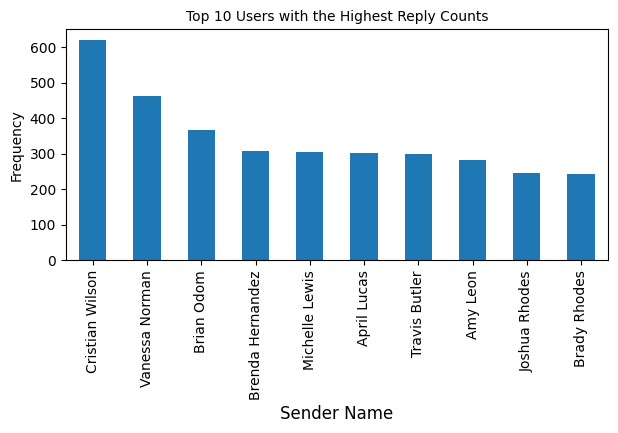

In [53]:
reply_counts = parsed_data.groupby('sender_name')['reply_count'].sum().sort_values(ascending=False)
reply_counts[:10].plot(kind='bar', figsize=(7, 3))
plt.title('Top 10 Users with the Highest Reply Counts', size=10)
plt.xlabel("Sender Name", size=12); plt.ylabel("Frequency", size=10);
plt.xticks(size=10); plt.yticks(size=10);
plt.show()


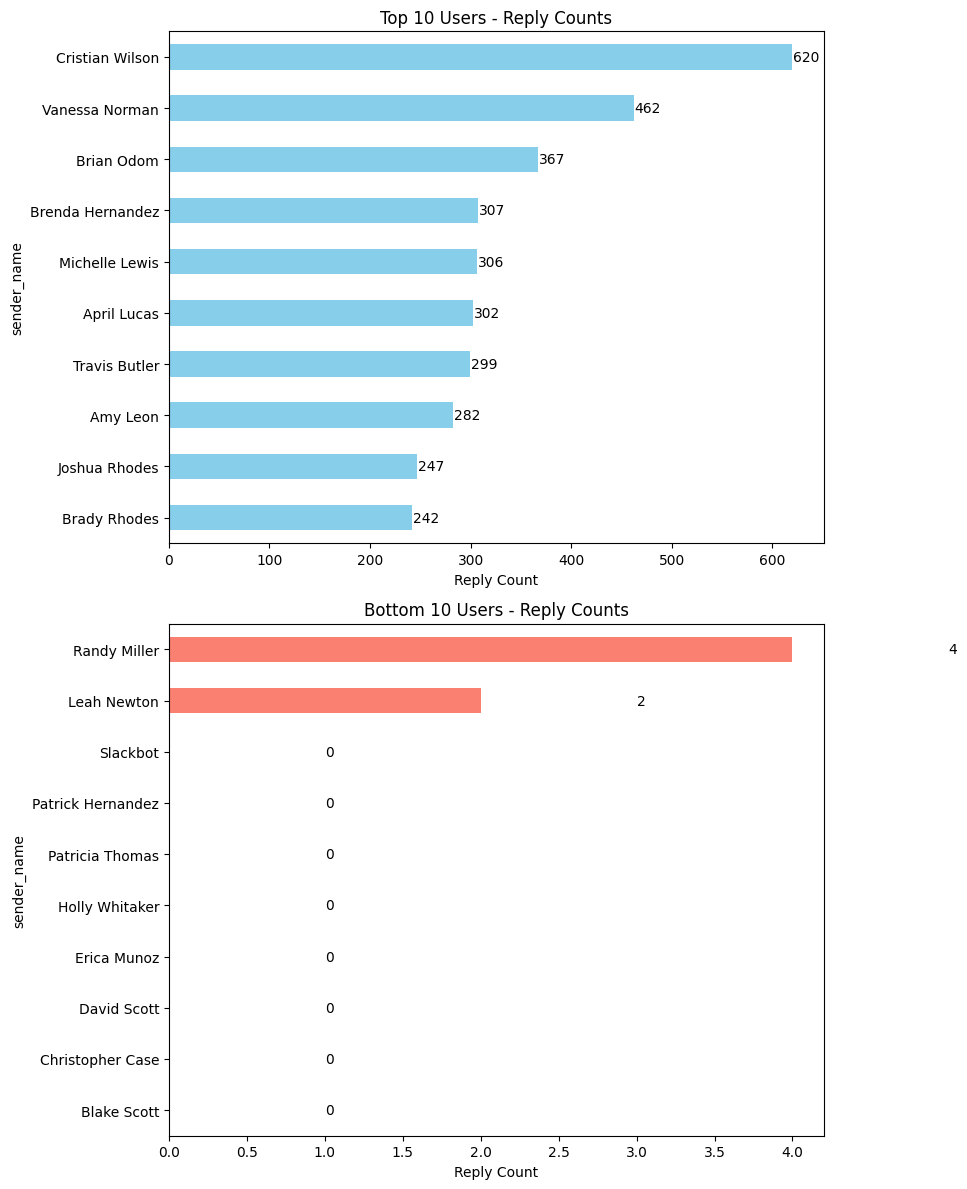

In [58]:
user_reply_counts = parsed_data.groupby('sender_name')['reply_count'].sum()
top_10_users_replies = user_reply_counts.nlargest(10)
bottom_10_users_replies = user_reply_counts.nsmallest(10)

fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# Plotting top 10 users with their reply counts
top_10_users_replies_sorted = top_10_users_replies.sort_values()
top_10_users_replies_sorted.plot(kind='barh', ax=axs[0], color='skyblue')
axs[0].set_xlabel('Reply Count')
axs[0].set_title('Top 10 Users - Reply Counts')

# Displaying top 10 users' reply counts
for i, v in enumerate(top_10_users_replies_sorted):
    axs[0].text(v + 1, i, str(v), color='black', va='center')

# Plotting bottom 10 users with their reply counts
bottom_10_users_replies_sorted = bottom_10_users_replies.sort_values()
bottom_10_users_replies_sorted.plot(kind='barh', ax=axs[1], color='salmon')
axs[1].set_xlabel('Reply Count')
axs[1].set_title('Bottom 10 Users - Reply Counts')

# Displaying bottom 10 users' reply counts
for i, v in enumerate(bottom_10_users_replies_sorted):
    axs[1].text(v + 1, i, str(v), color='black', va='center')

plt.tight_layout()
plt.show()


In [54]:
top_10_replies = parsed_data.nlargest(10, 'reply_count')[['msg_content', 'reply_count']]

print("Top 10 messages by reply count:")
print("================================")
for idx, row in top_10_replies.iterrows():
    print(f"Reply Count: {row['reply_count']} - Message: {row['msg_content']}")
    print("--------------------------------")

Top 10 messages by reply count:
Reply Count: 75 - Message: <@U03V1AM5TFA> how many crushes you have?
--------------------------------
Reply Count: 63 - Message: First Impression: People think I am older than I am,
Why: My hairline
--------------------------------
Reply Count: 61 - Message: 1. How do I find my jupyter notebook file in my instance(using the terminal)?  
2. How do I find folders I've created in my remote machine inside jupyter notebook web-interface?
<@U03UKL27B0R> <@U03V8LHPDME>
--------------------------------
Reply Count: 57 - Message: How many here follow football so much? I think it is almost everyone.
--------------------------------
Reply Count: 54 - Message: Ethiopian New year Loading ....
--------------------------------
Reply Count: 45 - Message: Hello
1. <@U03UVHCV6KB>
2. <@U03UG5VFN03>
3. <@U03UG0YHAUT>
4. <@U03UD4FEDHB>
5. <@U03UJGP0C68>
6. <@U03V61VGQG0>
7. <@U03UG32J3PC>
8. <@U03UG0SFHGT>
*IS IT EASY FOR YOU GUYS TO MEET FOR A GROUP PHOTO? WE NED ONE,* 
---

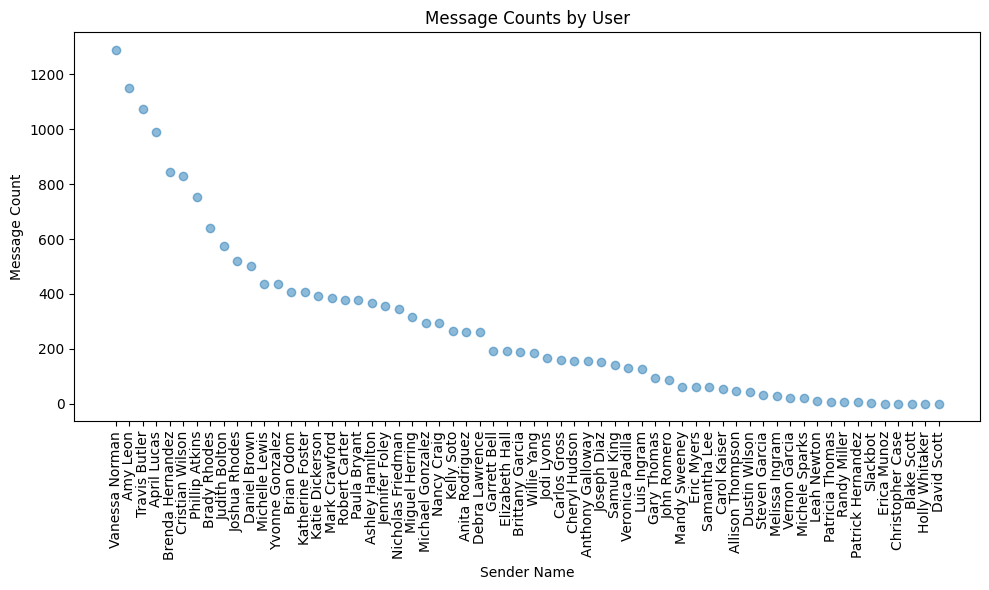

In [30]:
# User with the most messages
user_message_counts = parsed_data['sender_name'].value_counts()

user_message_counts_df = pd.DataFrame({'sender_name': user_message_counts.index, 'message_count': user_message_counts.values})

plt.figure(figsize=(10, 6))
plt.scatter(user_message_counts_df['sender_name'], user_message_counts_df['message_count'], alpha=0.5)
plt.xlabel('Sender Name')
plt.ylabel('Message Count')
plt.title('Message Counts by User')
plt.xticks(rotation=90)  # Rotating x-axis labels for better readability if needed
plt.tight_layout()
plt.show()

## Top 10 Users with most messages

<Figure size 1000x800 with 0 Axes>

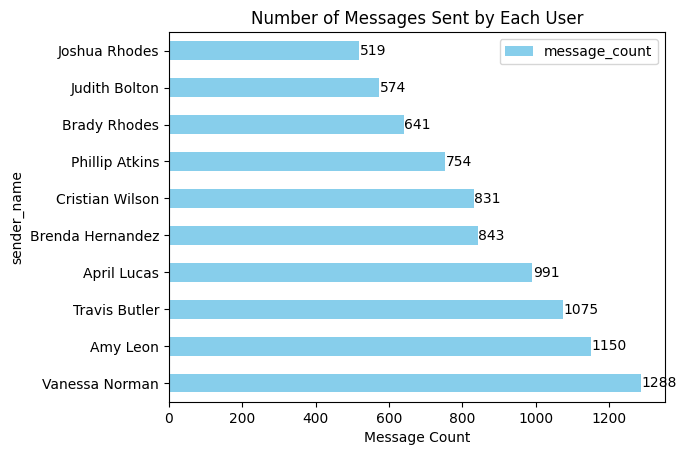

In [77]:
# Counting the number of messages sent by each user
user_message_counts = parsed_data.groupby('sender_name').size()

top_10_users = user_message_counts.nlargest(10)

user_message_counts_df = pd.DataFrame({'message_count': top_10_users.values}, index=top_10_users.index)

# Plotting the horizontal bar plot with annotations
plt.figure(figsize=(10, 8))
ax = user_message_counts_df.sort_values('message_count', ascending=False).plot(kind='barh', color='skyblue')
plt.xlabel('Message Count')
plt.title('Number of Messages Sent by Each User')

# Annotating counts near each bar
for i, (index, value) in enumerate(user_message_counts_df.iterrows()):
    ax.text(value['message_count'] + 1, i, str(value['message_count']), color='black', va='center')

plt.show()


## Bottom 10 with message count

<Figure size 1000x800 with 0 Axes>

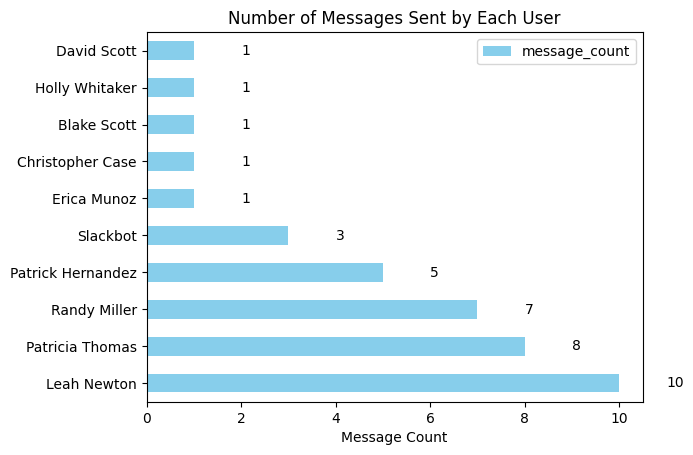

In [79]:
# User with the most messages
user_message_counts = parsed_data['sender_name'].value_counts()

top_10_users = user_message_counts.tail(10)

user_message_counts_df = pd.DataFrame({'message_count': top_10_users.values}, index=top_10_users.index)\


# Plotting the horizontal bar plot
plt.figure(figsize=(10, 8))
ax = user_message_counts_df.sort_values('message_count', ascending=False).plot(kind='barh', color='skyblue')
plt.xlabel('Message Count')
plt.title('Number of Messages Sent by Each User')

for i, (index, value) in enumerate(user_message_counts_df.iterrows()):
    ax.text(value['message_count'] + 1, i, str(value['message_count']), color='black', va='center')
plt.show()

## Top and Bottom 10 by mention

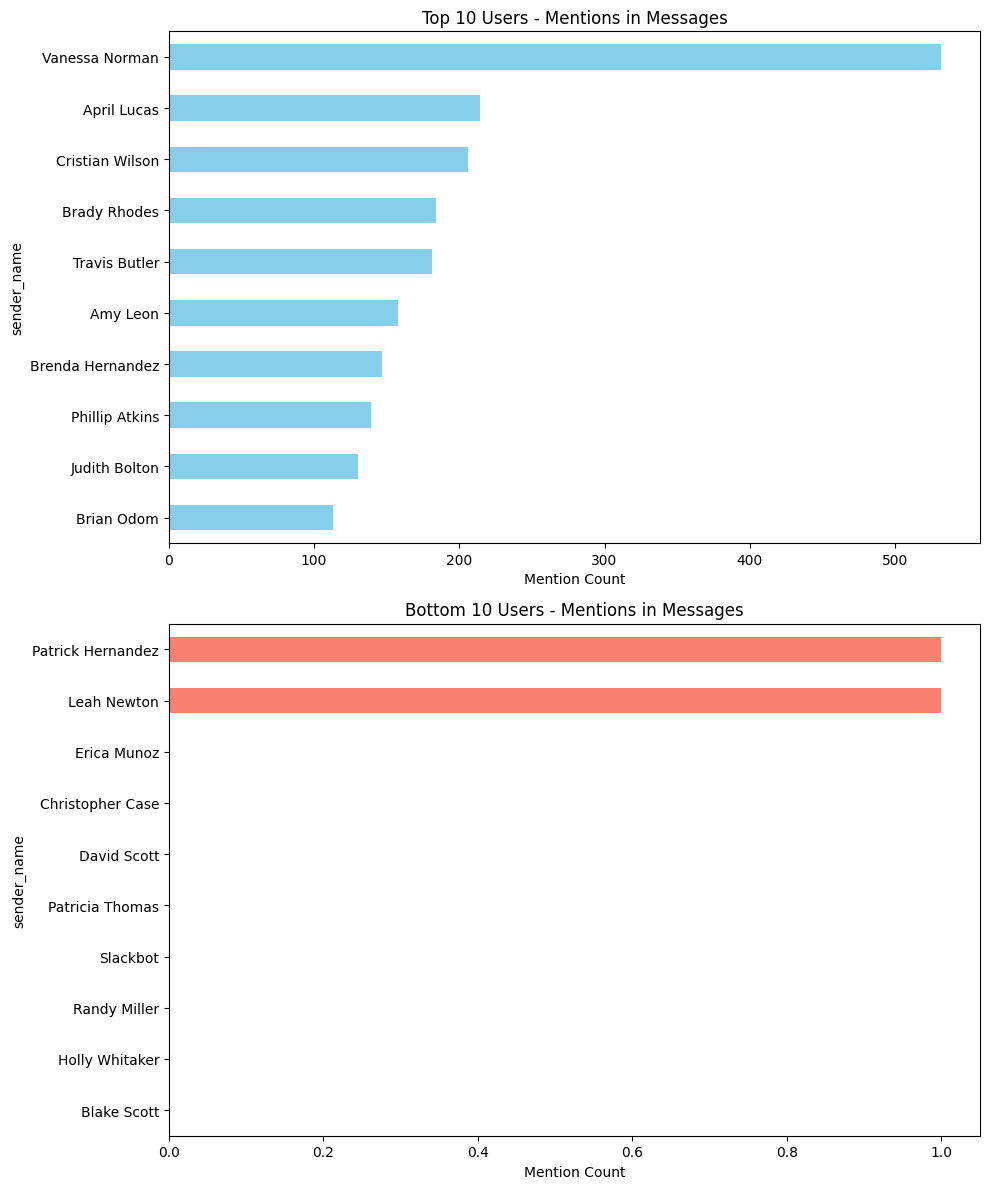

In [55]:
#Top 10 users with the highest number of mentions
mention_counts = parsed_data['msg_content'].str.count('@U\w+')

user_mention_counts = mention_counts.groupby(parsed_data['sender_name']).sum().sort_values(ascending=False)

top_10_users_mentions = user_mention_counts.nlargest(10)
bottom_10_users_mentions = user_mention_counts.nsmallest(10)

fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# Top 10 users by mention count
top_10_users_mentions.sort_values().plot(kind='barh', ax=axs[0], color='skyblue')
axs[0].set_xlabel('Mention Count')
axs[0].set_title('Top 10 Users - Mentions in Messages')

# Bottom 10 users by mention count
bottom_10_users_mentions.sort_values().plot(kind='barh', ax=axs[1], color='salmon')
axs[1].set_xlabel('Mention Count')
axs[1].set_title('Bottom 10 Users - Mentions in Messages')

plt.tight_layout()
plt.show()

/tmp/ipykernel_26190/3010717355.py:64: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


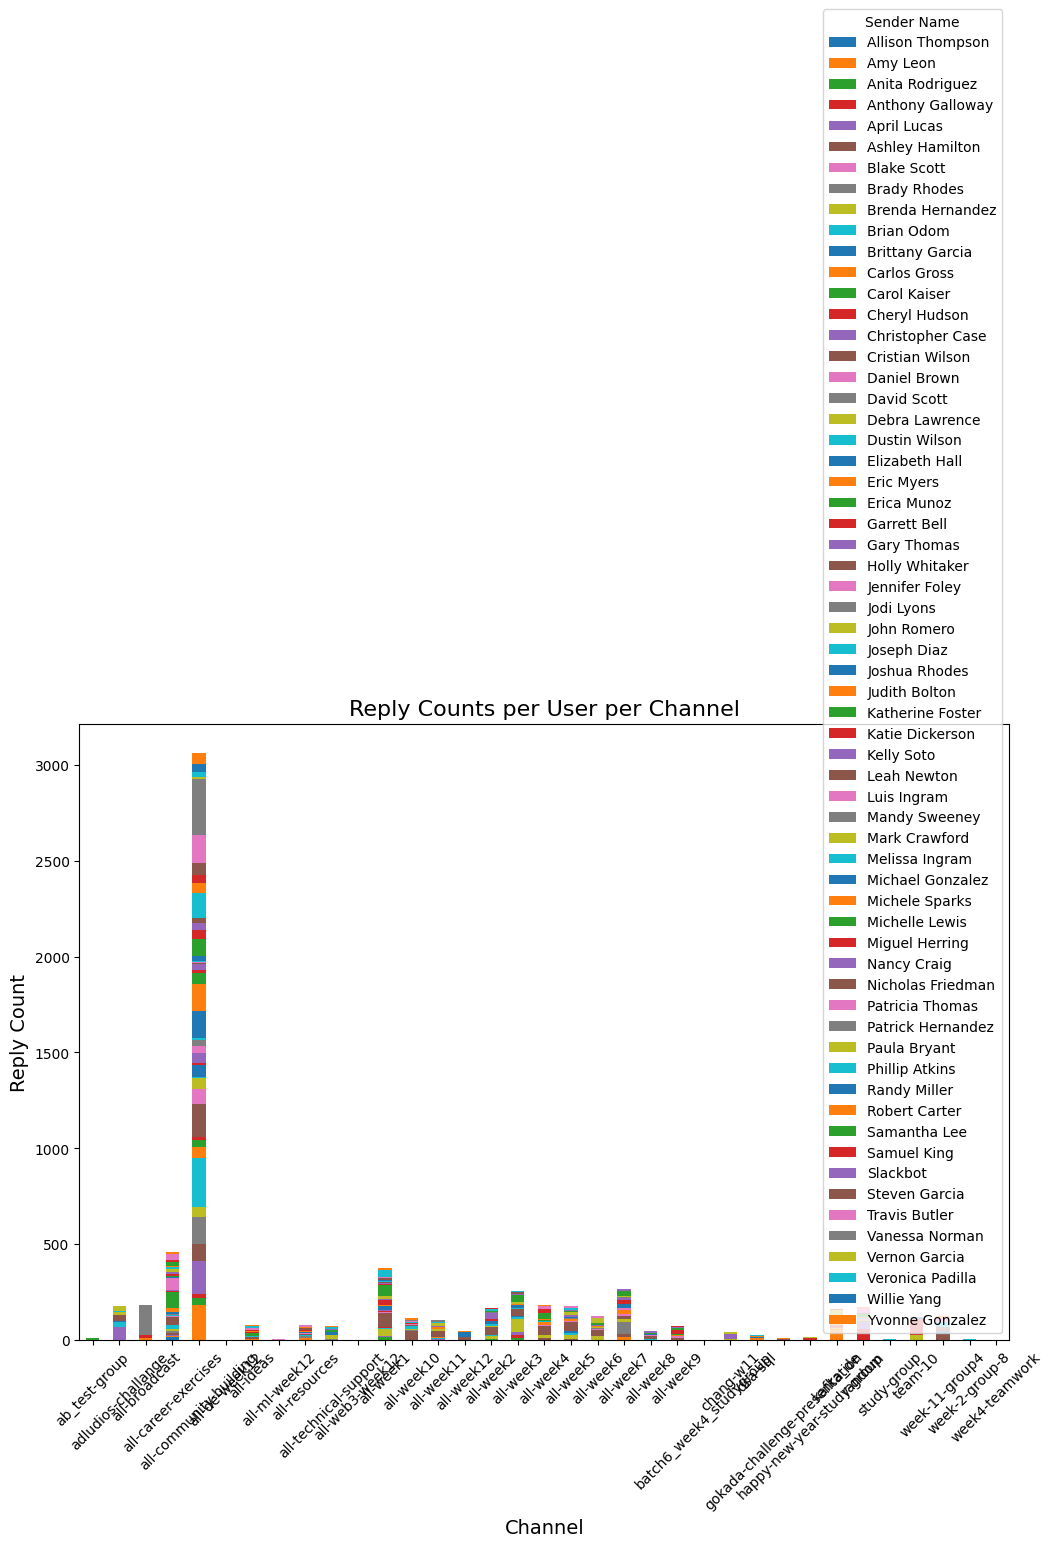

In [81]:
# Visualize reply counts per user per channel
draw_user_reaction(parsed_data)

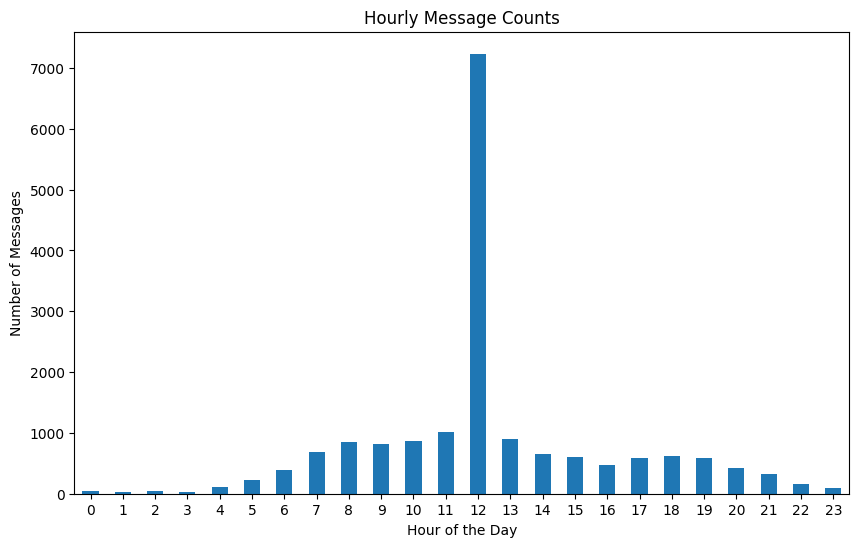

The hour with the most messages is 12:00 with 7233 messages.


In [35]:
# Convert 'msg_sent_time' column to datetime format
parsed_data['msg_sent_time'] = pd.to_datetime(parsed_data['msg_sent_time'], unit='s')

# Extract hour from message timestamps
parsed_data['hour_sent'] = parsed_data['msg_sent_time'].dt.hour

# Group messages by hour and count the number of messages in each hour
hourly_message_count = parsed_data.groupby('hour_sent').size()

# Find the hour with the maximum number of messages
hour_peak = hourly_message_count.idxmax()
max_messages = hourly_message_count.max()

# Visualize hourly message counts
hourly_message_count.plot(kind='bar', figsize=(10, 6))
plt.title('Hourly Message Counts')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Messages')
plt.xticks(rotation=0)
plt.show()

print(f"The hour with the most messages is {hour_peak}:00 with {max_messages} messages.")

In [38]:
message_counts_per_channel = parsed_data['channel'].value_counts()
print(message_counts_per_channel)

all-community-building           7613
all-resources                    1464
kafka_de                          898
all-career-exercises              782
random                            581
adludios-challange                574
all-week1                         551
ab_test-group                     546
all-broadcast                     537
all-week7                         456
all-week5                         449
all-week3                         387
team-10                           343
all-week6                         301
all-week4                         290
all-week2                         268
all-ideas                         253
all-week11                        226
week-11-group4                    179
all-week10                        164
all-technical-support             134
all-week9                         110
happy-new-year-study-group         93
chang-w11                          93
week4-teamwork                     81
all-week8                          79
dsa-sql     

In [40]:
reply_counts_per_channel = parsed_data.groupby('channel')['reply_count'].sum()
print(reply_counts_per_channel)

channel
ab_test-group                       8
adludios-challange                178
all-broadcast                     179
all-career-exercises              460
all-community-building           3062
all-de-week12                       0
all-ideas                          79
all-ml-week12                       2
all-resources                      78
all-technical-support              72
all-web3-week12                     0
all-week1                         372
all-week10                        112
all-week11                        102
all-week12                         46
all-week2                         168
all-week3                         256
all-week4                         180
all-week5                         177
all-week6                         124
all-week7                         264
all-week8                          45
all-week9                          71
batch6_week4_studygroup             0
chang-w11                          40
dsa-sql                            23
goka

In [ ]:
channel_activity['Total_Activity'] = channel_activity['Messages'] + channel_activity['Replies'] + channel_activity['Reactions']

plt.figure(figsize=(10, 6))
plt.scatter(channel_activity['Messages'], channel_activity['Total_Activity'], c=range(len(channel_activity)), cmap='viridis')
plt.xlabel('Number of Messages')
plt.ylabel('Sum of Replies and Reactions')
plt.title('Channel Activity')
plt.colorbar(label='Channels')
plt.show()

In [ ]:
# parsed_data = pd.DataFrame()
unique_channels = parsed_data['channel'].unique()
unique_channels_list = unique_channels.tolist()
print(unique_channels_list)

In [ ]:
# what kind of messages are replied faster than others?


In [ ]:
# Relationship between # of messages and # of reactions

In [ ]:
# Classify messages into different categories such as questions, answers, comments, etc.

In [ ]:
# Which users got the most reactions?

In [ ]:
# Model topics mentioned in the channel

In [ ]:
# What are the topics that got the most reactions?

### Harder questions to look into

In [ ]:
# Based on messages, reactions, references shared, and other relevant data such as classification of questions into techical question, comment, answer, aorder stu the python, statistics, and sql skill level of a user?